## Toliman Pupil Characterisation ✨

This notebook calculates the phase errors on the manufactured Toliman pupil.

Existing system aberrations are loaded and can be calculated using System_Aberrations.ipynb

In [1]:
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dLT

import jax.numpy as jnp
import numpy as np
import jax.scipy as jsp

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'upper' # true reading of array
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

data_dir = "/import/morgana2/gpir9156/toliman/"

# Detector response (gamma curve)
alpha = np.load(data_dir+"detector/80us_detector/ALPHA_norm.npy")
beta = np.load(data_dir+"detector/80us_detector/BETA_norm.npy")
gamma = np.load(data_dir+"detector/80us_detector/GAMMA_norm.npy")


### Simulation Parameters

In [25]:
# Source(s)
red_laser_wl =  635e-09  # for laser data
# green_laser_wl = 520e-09  # """ # starting with just red data for now
# thermal_wls = np.linspace(525, 625, 100)
src = dl.sources.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))

# Aperture parameters
mask_path = "diffractive_pupil.npy"
mask = np.load(mask_path)
ratio = 1  # Ratio to scale the aperture by (e.g. 5 => 5-inch aperture becomes 1-inch aperture)
aperture_npix = mask.shape[0]  # Number of pixels across the aperture
aperture_diameter = 0.125 / ratio  # Clear aperture diameter (m)
secondary_diameter = 0.032 / ratio  # Secondary mirror diameter (m)
spider_width = 0.002 / ratio  # Spider width (m)

# Mask layer - geometric phase 
mask *= np.pi
mask_layer = dl.BasisLayer(basis=np.array([mask]), coefficients=np.array([1]), as_phase=True)

# Detector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350               # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

psf_npix = 256                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)             # half window sz of cropped data
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 


Custom spider layer, able to rotate

In [26]:
class TolimanSpiderLayer(dl.layers.optics.BasisOptic):
    """
        Class inherited from dLux Basis Optic. Same functionality 
        with the additional parameter to apply a global rotation to the 
        transmission array. 

        Attributes
        ----------
        basis: Array, metres
            Arrays holding the pre-calculated basis vectors.
        transmission: Array
            The Array of transmission values to be applied to the input wavefront.
        coefficients: Array = None
            The Array of coefficients to be applied to each basis vector.
        as_phase : bool = False
            Whether to apply the basis as a phase phase or OPD. If True the basis is
            applied as a phase, else it is applied as an OPD.
        normalise: bool
            Whether to normalise the wavefront after passing through the optic.
        rotation: Array
            Rotation of transmission array, radians. Array of shape (1,) (zodiax 
            artefact requires array to optimise on single value).
    """
    rotation: jnp.array

    def __init__(
        self: dl.layers.optical_layers.OpticalLayer , 
        basis,
        transmission: jnp.array = None,
        coefficients=None,
        as_phase=False,
        normalise: bool = False,
        rotation: jnp.array=jnp.array([0.0]),
    ):
        self.rotation = rotation

        super().__init__(basis=basis,
                         transmission=transmission, 
                         coefficients=coefficients,
                         as_phase=as_phase,
                         normalise=normalise,
                         )

    
    def apply(self: dl.layers.optical_layers.OpticalLayer , wavefront: dl.wavefronts.Wavefront) -> dl.wavefronts.Wavefront:
        """
        Applies the layer to the wavefront.

        Parameters
        ----------
        wavefront : Wavefront
            The wavefront to operate on.

        Returns
        -------
        wavefront : Wavefront
            The transformed wavefront.
        """
        wavefront *= dlu.rotate(array=self.transmission, angle=self.rotation) 

        if self.as_phase:
            wavefront = wavefront.add_phase(self.eval_basis())
        else:
            wavefront += self.eval_basis()

        if self.normalise:
            wavefront = wavefront.normalise()
        return wavefront


Non-uniform fiber intensity.

Fitting process in general performs better with this.

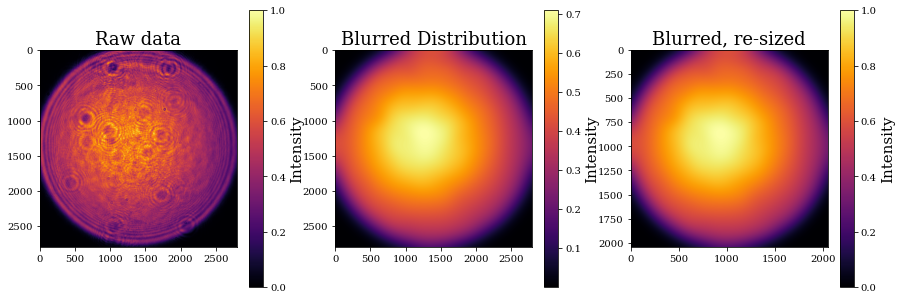

In [52]:
# intensity_dist = np.load(data_dir+"spider/11_11_2024/RHCP_intensity_img_80us_0gain_img_stack_batch_0.npy")[0,:]
intensity_dist = np.load(data_dir+"intensity/15_07_intensity_img_stack.npy")[0,:]
intensity_dist = np.flipud(intensity_dist)

manual_cen = [1900,2800]#[2035,2625] # [row, col]
hlf_sz = 1400 #260             # px
plt.figure(figsize=(15,5))
intensity_dist = intensity_dist[manual_cen[0]-hlf_sz:manual_cen[0]+hlf_sz, manual_cen[1]-hlf_sz:manual_cen[1]+hlf_sz]
intensity_dist = 0 + (1-0)/(intensity_dist.max()- intensity_dist.min())*(intensity_dist - intensity_dist.min())
plt.subplot(1,3,1)
plt.imshow(intensity_dist)
plt.title("Raw data")
plt.colorbar(label="Intensity")
# plt.plot(manual_cen[1], manual_cen[0], 'yx')

plt.subplot(1,3,2)
# blurred = ski.filters.gaussian(intensity_dist, sigma=(30, 30))
blurred = ski.filters.gaussian(intensity_dist, sigma=(120, 120))

plt.imshow(blurred)
plt.title("Blurred Distribution")
plt.colorbar(label="Intensity")

plt.subplot(1,3,3)
resized = resize(blurred, (aperture_npix, aperture_npix))
resized = 0 + (1-0)/(resized.max()- resized.min())*(resized - resized.min())
plt.imshow(resized)
plt.title("Blurred, re-sized")
plt.colorbar(label="Intensity")

System aberrations. Using RHCP data to calibrate this. I imagine it would change slightly with rotation of polariser but not sure if by a significant amount.

System Coefficients (noll [ 4  5  6  7  8  9 10 11 12 13 14]): [ 2.89585739e-09 -3.95500919e-09  1.20750780e-08 -2.77219038e-09
 -7.09704327e-09  4.77169970e-09 -4.29659264e-09 -6.93444662e-09
 -1.26191466e-09 -3.92156436e-10  2.22673074e-09]


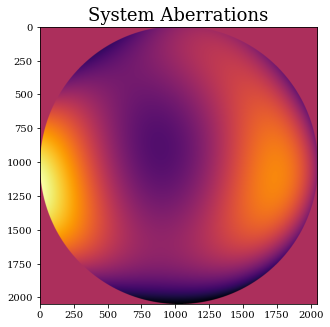

In [53]:
f_aberr = "data/spider/retrieval_results/11_11_mean_coeffs_combined.npy"
syst_noll = jnp.arange(4, 15) # only first 14 Zernike modes (excluding piston and tip/tilt) are used to classify syst aberrations
syst_coeffs = np.load(f_aberr)
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter) 
syst_basis = dlu.zernike_basis(js=syst_noll, diameter=aperture_diameter, coordinates=coords)
print("System Coefficients (noll {}): {}".format(syst_noll,syst_coeffs))
basis_eval = np.tensordot(syst_basis, syst_coeffs, axes=2 * (tuple(range(syst_coeffs.ndim)),))

plt.figure(figsize=(5,5))
plt.title("System Aberrations")
plt.imshow(basis_eval)

In [54]:
# Optical system
zernike_indices = np.arange(4,21)
os = dLT.TolimanOpticalSystem(        
        wf_npixels=aperture_npix,
        psf_npixels=psf_npix,
        oversample=1,
        psf_pixel_scale=psf_pixel_scale,
        mask=mask_layer,
        noll_indices=zernike_indices,
        )
existing_aperture = os.aperture
new_aperture = TolimanSpiderLayer(basis=existing_aperture.basis, 
                             transmission=existing_aperture.transmission, 
                             coefficients=existing_aperture.coefficients,
                             as_phase=existing_aperture.as_phase,
                             normalise=existing_aperture.normalise
                        )
os_plus = os.remove_layer("aperture") # replace default layer with one that can rotate
os_plus = os_plus.insert_layer(layer=("aperture", new_aperture),index=1)

os_plus = os_plus.insert_layer(layer=("intensity_dist", dl.TransmissiveLayer(transmission=resized)),index=1)
os_plus = os_plus.insert_layer(layer=("upstream_aberrations", dl.BasisLayer(basis=syst_basis, coefficients=syst_coeffs)),index=1)

# Combined system
model = dl.Telescope(os_plus, ('source', src))

print(model)

Telescope(
  optics=TolimanOpticalSystem(
    wf_npixels=2048,
    diameter=0.125,
    layers={
      'pupil':
      BasisLayer(basis=f32[1,2048,2048], coefficients=f32[1], as_phase=True),
      'upstream_aberrations':
      BasisLayer(basis=f32[11,2048,2048], coefficients=f32[11], as_phase=False),
      'intensity_dist':
      TransmissiveLayer(transmission=f32[2048,2048], normalise=False),
      'aperture':
      TolimanSpiderLayer(
        basis=f32[17,2048,2048],
        coefficients=f32[17],
        as_phase=False,
        transmission=f32[2048,2048],
        normalise=True,
        rotation=f32[1]
      )
    },
    psf_npixels=256,
    oversample=1,
    psf_pixel_scale=0.3807965653791467
  ),
  source=PointSources(
    spectrum=Spectrum(wavelengths=f32[1], weights=f32[1]),
    position=f32[1,2],
    flux=f32[1]
  ),
  detector=None
)


Display model

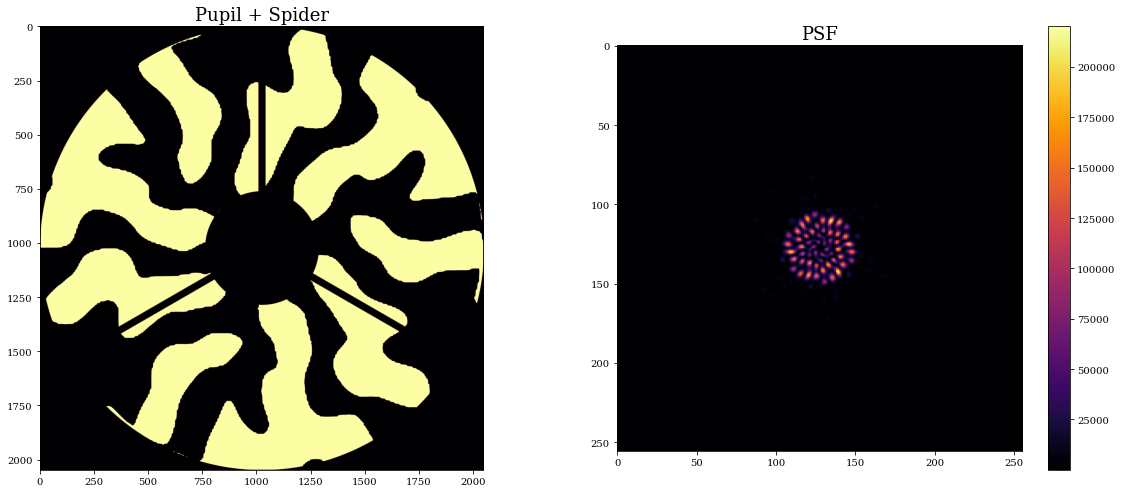

In [55]:
%matplotlib inline
psf = model.model()
pupil_basis = model.optics.pupil.eval_basis()
spider = model.optics.aperture.transmission
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(pupil_basis*spider)
plt.title("Pupil + Spider")
plt.subplot(1,2,2)
plt.imshow(psf)
plt.title("PSF")
plt.colorbar()

### Define Loss function
(and parameters we care to fit)

In [56]:
params = [
    'aperture.coefficients',
    'aperture.rotation',
    'source.position',
    'source.flux', 
    ]

learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=1e-3),
            optax.adam(learning_rate=1e-8),
            optax.adam(learning_rate=1e6),
              ]

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum() 


    return loss


### Load in data
- Trying just red laser wl data for now

In [58]:
data_fnames = [
                # "diffractive_pupil/11_11_2024/RHCP_red_img_69us_0gain_img_stack_batch_0.npy",   
                "diffractive_pupil/diffractive_pupil_img_wspider_160us_1.84gain_img_stack_batch_0.npy",
            ]

bckgnd_fnames = [
                # "diffractive_pupil/11_11_2024/RHCP_red_img_bckgnd_80us_0gain_img_stack_batch_0.npy"
            ]

data = [np.load(data_dir+fname)[-1,:] for fname in data_fnames] # take last frame for now
bckgnd = [np.mean(np.load(data_dir+fname)) for fname in data_fnames]
data_proc = [np.abs(img - bckgnd[i]) for i, img in enumerate(data)]

calib_frame = data_proc[0]
cen = np.unravel_index(np.argmax(calib_frame, axis=None), calib_frame.shape)
hlf_sz_psf = int(psf_npix/2) # for psf sz
data_proc_cropped = [img[cen[0]-hlf_sz_psf:cen[0]+hlf_sz_psf, cen[1]-hlf_sz_psf:cen[1]+hlf_sz_psf] for img in data_proc]

In [59]:
alpha_cropped = alpha[cen[0]-hlf_sz_psf:cen[0]+hlf_sz_psf,cen[1]-hlf_sz_psf:cen[1]+hlf_sz_psf]
beta_cropped = beta[cen[0]-hlf_sz_psf:cen[0]+hlf_sz_psf,cen[1]-hlf_sz_psf:cen[1]+hlf_sz_psf]
gamma_cropped = gamma[cen[0]-hlf_sz_psf:cen[0]+hlf_sz_psf,cen[1]-hlf_sz_psf:cen[1]+hlf_sz_psf]

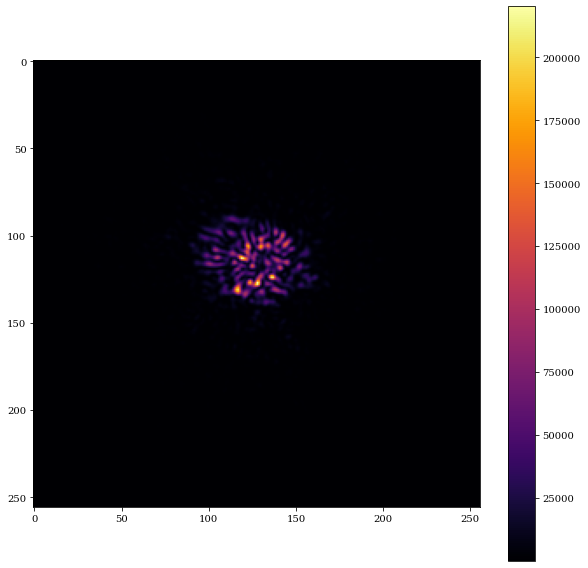

In [60]:
img = data_proc_cropped[0]
data_remapped = 0.0 + ((1.0 - 0.0)/(img.max()-img.min()))*(img - img.min()) #[0,1] otput range
data_remapped = np.flipud(data_remapped)
img_corrected = np.power((data_remapped-np.flipud(alpha_cropped))/np.flipud(beta_cropped), (1/np.flipud(gamma_cropped))) # flip about origin

# Scale intensity
data_corrected = psf.min() + (psf.max() - psf.min())/(img_corrected.max() - img_corrected.min())\
    *(img_corrected-img_corrected.min())
plt.imshow(data_corrected)
plt.colorbar()

In [61]:
current_model = model

for param_str in params:
    print("Parameter {} set to {}".format(param_str, current_model.get(param_str)))

loss, grad = loss_fn_poisson(current_model, data_corrected)
print("Loss: ", loss)
for param_str in params:
    print("Parameter {} gradients: {}".format(param_str, grad.get(param_str)))

Parameter aperture.coefficients set to [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Parameter aperture.rotation set to [0.]
Parameter source.position set to [[0. 0.]]
Parameter source.flux set to [1.e+08]
Loss:  144051580.0
Parameter aperture.coefficients gradients: [ 2.3654239e+13  1.5681468e+13 -2.1563850e+14 -4.1655269e+13
  6.1243390e+13  3.4004135e+13  5.2444113e+13  3.1723411e+13
  7.1263591e+13  5.6267725e+13  1.3261040e+13 -3.6680573e+13
 -7.5050678e+13  1.9464871e+13  3.6917729e+12  2.9328138e+13
 -1.5606932e+13]
Parameter aperture.rotation gradients: [-29206654.]
Parameter source.position gradients: [[-7.8893731e+11  4.2907654e+12]]
Parameter source.flux gradients: [1.3136522]


In [62]:
optim, opt_state = zdx.get_optimiser(current_model, params, optimisers)

progress_bar = tqdm(range(4000), desc='Loss: ')

# Run optimisation loop 
net_losses, Coeffs, Positions, Fluxes, Rotations= [],[],[],[], []
for j in progress_bar:
    poiss_loss, poiss_grads = loss_fn_poisson(model = current_model, data = data_corrected)

    updates, opt_state = optim.update(poiss_grads, opt_state)
    current_model = zdx.apply_updates(current_model, updates) 

    net_losses.append(poiss_loss)
    Fluxes.append(current_model.source.flux)
    Coeffs.append(current_model.aperture.coefficients)
    Positions.append(current_model.source.position)
    Rotations.append(current_model.rotation)

    progress_bar.set_postfix({'Loss': poiss_loss})


Loss:   0%|          | 0/4000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Residuals')

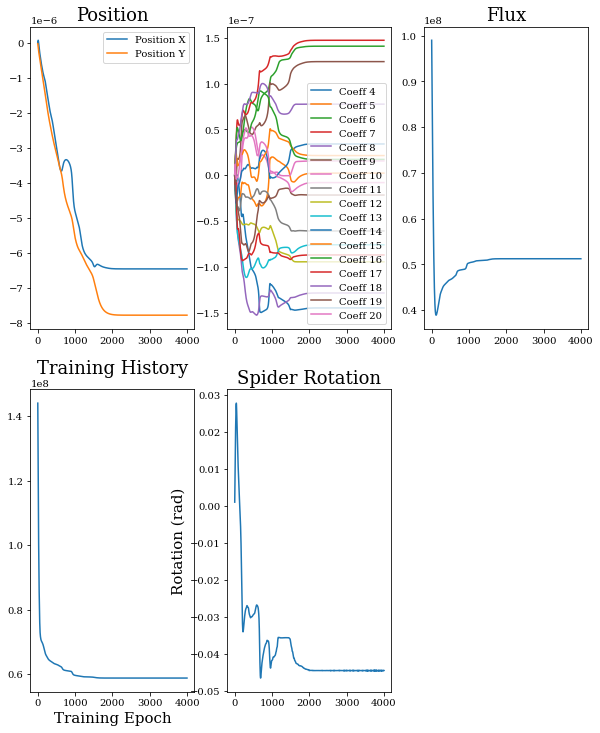

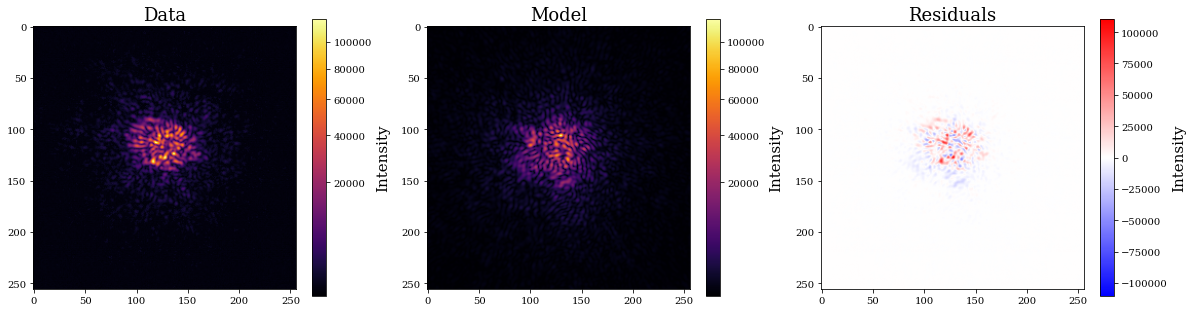

In [63]:
plt.figure(figsize=(10,12))
plt.subplot(2,3,1)
plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
plt.title("Position")
plt.legend()
plt.subplot(2,3,2)
arr_coeffs = np.asarray(Coeffs)
for l in range(len(Coeffs[0])):
    label = "Coeff " + str(zernike_indices[l])
    plt.plot(arr_coeffs[:,l], label=label)
plt.legend()
plt.subplot(2,3,3)
plt.plot(np.asarray(Fluxes))
plt.title("Flux")
plt.subplot(2,3,4)
plt.plot(np.array(net_losses))
ax = plt.gca()
ax.set_title("Training History")
ax.set_xlabel("Training Epoch")
plt.subplot(2,3,5)
plt.plot(np.asarray(Rotations))
plt.title("Spider Rotation")
plt.ylabel("Rotation (rad)")

plt.figure(figsize=(20,5))
model_psf = current_model.model()

plt.subplot(1,3,1)
data_corrected_rescaled = model_psf.min() + (model_psf.max()-model_psf.min())/(data_corrected.max()-data_corrected.min())*(data_corrected-data_corrected.min())
# norm_psf = PowerNorm(gamma=0.5, vmin=data_corrected.min(), vmax=data_corrected.max())
# plt.imshow(data_corrected, norm=norm_psf)
norm_psf = PowerNorm(gamma=0.5, vmin=data_corrected_rescaled.min(), vmax=data_corrected_rescaled.max())
plt.imshow(data_corrected_rescaled, norm=norm_psf)
plt.colorbar(label="Intensity")
plt.title("Data")
plt.subplot(1,3,2)
norm_psf = PowerNorm(gamma=0.5, vmin=model_psf.min(), vmax=model_psf.max())
plt.imshow(model_psf, norm=norm_psf)
plt.colorbar(label="Intensity")
plt.title("Model")
plt.subplot(1,3,3)
# resid = data_corrected - model_psf 
resid = data_corrected_rescaled - model_psf 
plt.imshow(resid, cmap='bwr', vmin=-np.abs(np.max(resid)), vmax=np.max(resid))
plt.colorbar(label="Intensity")
plt.title("Residuals")
